# Machine learning models to predict rental price per day

This notebook serves for the following features below:
*    pipelines to train a various type of machine learning model
*    tuning hyperparameters of ML models
*    checking if there is any overfitting by using cross validation
*    choosing model with best score 
*    exporting model

Note:  This notebook is adapted from one of earlier projects that I took place.
    ref. https://github.com/LHB-Group/Civil-Work-Bidding-And-Investment-Helper

## Setup

In [2]:
import numpy as np
import pandas as pd

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb


pd.options.display.max_columns = None
pd.options.display.max_rows = None

import os 

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Start of User Input
fname1= "../data/get_around_pricing_project_clean.csv"
dataset = pd.read_csv(fname1, low_memory=False)

In [4]:
dataset.shape

(4655, 31)

In [5]:
dataset.head(5)

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day,model_key_,fuel_,paint_color_,factorized_model_key,factorized_fuel,factorized_paint_color,factorized_car_type,factorized_private_parking_available,factorized_has_gps,factorized_has_air_conditioning,factorized_automatic_car,factorized_has_getaround_connect,factorized_has_speed_regulator,factorized_winter_tires,factorized_model_key_,factorized_fuel_,factorized_paint_color_
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106,Citroën,diesel,black,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101,Citroën,diesel,white,0,0,1,0,1,1,0,0,0,1,0,0,0,1
2,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158,Citroën,diesel,red,0,0,2,0,0,0,0,0,0,0,0,0,0,2
3,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183,Citroën,diesel,silver,0,0,3,0,0,0,0,0,1,0,0,0,0,3
4,Citroën,152352,225,petrol,black,convertible,True,True,False,False,True,True,True,131,Citroën,petrol,black,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
dataset.columns

Index(['model_key', 'mileage', 'engine_power', 'fuel', 'paint_color',
       'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires', 'rental_price_per_day',
       'model_key_', 'fuel_', 'paint_color_', 'factorized_model_key',
       'factorized_fuel', 'factorized_paint_color', 'factorized_car_type',
       'factorized_private_parking_available', 'factorized_has_gps',
       'factorized_has_air_conditioning', 'factorized_automatic_car',
       'factorized_has_getaround_connect', 'factorized_has_speed_regulator',
       'factorized_winter_tires', 'factorized_model_key_', 'factorized_fuel_',
       'factorized_paint_color_'],
      dtype='object')

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655 entries, 0 to 4654
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   model_key                             4655 non-null   object
 1   mileage                               4655 non-null   int64 
 2   engine_power                          4655 non-null   int64 
 3   fuel                                  4655 non-null   object
 4   paint_color                           4655 non-null   object
 5   car_type                              4655 non-null   object
 6   private_parking_available             4655 non-null   bool  
 7   has_gps                               4655 non-null   bool  
 8   has_air_conditioning                  4655 non-null   bool  
 9   automatic_car                         4655 non-null   bool  
 10  has_getaround_connect                 4655 non-null   bool  
 11  has_speed_regulator           

## Target and features

**Target**
* rental_price_per_day

**Features**
* very well correlated: engine_power, automatic_car, mileage

* well correlated: model_key_, has_getaround_connect, has_gps, car_type, private_parking_available, has_air_conditioning, has_speed_regulator

* slightly correlated: paint_color_, fuel_, winter_tires

At first attempt, I factorize features of boolean and object types. It will allow me to print feature importance of features.

In [8]:
# Separate target variable Y from features X
print("Separating labels from features...")

features_list = [
    "factorized_model_key_",
    "mileage",
    "engine_power",
    "factorized_fuel_",
    "factorized_paint_color_", 
    "factorized_car_type",
    "factorized_private_parking_available", 
    "factorized_has_gps",
    "factorized_has_air_conditioning", 
    "factorized_automatic_car",
    "factorized_has_getaround_connect", 
    "factorized_has_speed_regulator",
    "factorized_winter_tires"
    ]

target_variable = "rental_price_per_day"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    106
1    101
2    158
3    183
4    131
Name: rental_price_per_day, dtype: int64

X :
   factorized_model_key_  mileage  engine_power  factorized_fuel_  \
0                      0   140411           100                 0   
1                      0   183297           120                 0   
2                      0   128035           135                 0   
3                      0    97097           160                 0   
4                      0   152352           225                 1   

   factorized_paint_color_  factorized_car_type  \
0                        0                    0   
1                        1                    0   
2                        2                    0   
3                        3                    0   
4                        0                    0   

   factorized_private_parking_available  factorized_has_gps  \
0                                     0                   0   
1          

In [9]:

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('\nFound numeric features ', numeric_features)
print('\nFound categorical features ', categorical_features)


Found numeric features  ['factorized_model_key_', 'mileage', 'engine_power', 'factorized_fuel_', 'factorized_paint_color_', 'factorized_car_type', 'factorized_private_parking_available', 'factorized_has_gps', 'factorized_has_air_conditioning', 'factorized_automatic_car', 'factorized_has_getaround_connect', 'factorized_has_speed_regulator', 'factorized_winter_tires']

Found categorical features  []


## Preprocessor
Numeric features : standardizing, scaling, replacing remained missing values by median of column values
Categorical features : one hot encoding as they are nominals

In [10]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Defining train/test sets
With the use of the train_test_split function, the dataset, 75% for training data and 25% for test data, is seperated.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=0)

print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

# Test pipeline
print("Preprocessing X_test...")
print()
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print()

Preprocessing X_train...

...Done!
[[-1.07471708 -0.66545708  0.17682921 -0.19166494 -1.07659657 -0.97574804
  -0.90299093 -0.50035804 -0.50438252 -0.49543042 -1.06851195 -1.80049946
  -0.26619334]
 [ 0.24097843 -0.37452657 -1.14605515 -0.19166494  0.53196265 -0.36265653
   1.10743084 -0.50035804 -0.50438252 -0.49543042  0.93588097 -1.80049946
  -0.26619334]
 [-0.28529977 -0.65116955 -1.14605515 -0.19166494  0.53196265  0.25043497
   1.10743084 -0.50035804  1.98262224 -0.49543042  0.93588097  0.55540144
  -0.26619334]
 [ 0.24097843  0.13967266  0.17682921 -0.19166494  0.93410246  1.47661799
  -0.90299093 -0.50035804 -0.50438252  2.0184469  -1.06851195  0.55540144
  -0.26619334]
 [ 1.81981305  0.47936671  0.83827139 -0.19166494 -1.07659657  1.47661799
   1.10743084 -0.50035804 -0.50438252  2.0184469   0.93588097  0.55540144
  -0.26619334]]

Preprocessing X_test...

...Done!
[[-1.07471708 -1.18910544  0.83827139 -0.19166494 -0.67445676 -0.97574804
   1.10743084  1.99856887 -0.50438252 -0

## Metric and evalutation process
We use the root mean squared error (RMSE) to assess the performance of the models since we try to predict rental price per day. The resulted error value will be in dollars and easy to comprehend.

We use the cross_val_score function of sklearn to evaluate a score by cross-validation.

Then, we use the function Kfold where shuffle = True to allow a shuffle attribution as cross_val_score does not have this option.

In [12]:
#root mean squared error for 5-folds cross validation
n_folds = 4
random_state = 0
def rmse_cv(model,random_state,n_folds, x, y):
    random_state = random_state
    n_folds = n_folds
    kf = KFold(n_folds, shuffle=True, random_state=random_state).split(X_train)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Baseline regressor
I choose a dummy model below that systematically predict the mean target value. Then, I compute RMSE cross validation score for this dummy model. It can give an idea whether our models improve the predictions really or not.

In [14]:
dummy_predictions_scores = []

for test_fold in np.array_split(Y_train, 4):
    mean_value_vector = np.full(len(test_fold), Y_train.mean())
    score = mean_squared_error(y_true = test_fold, y_pred= mean_value_vector ,squared = False)
    dummy_predictions_scores.append(score)

dummy_predictions_scores = np.array(dummy_predictions_scores)
print("Dummy predictions' score : RMSE = {} with a standard deviation of {}"\
    .format(round(dummy_predictions_scores.mean(),2), round(dummy_predictions_scores.std(),2)))

Dummy predictions' score : RMSE = 28.97 with a standard deviation of 0.72


## Linear regression

Let's start with basic linear regressor

In [15]:
# create model
linear_regressor= LinearRegression()
# computing cross validation scores
linear_regression_scores = rmse_cv(linear_regressor,random_state, n_folds, X_train, Y_train)

print("simple linear regression : RMSE = {} with a standard deviation of {}".format(round(linear_regression_scores.mean(),2), round(linear_regression_scores.std(),2)))

simple linear regression : RMSE = 16.35 with a standard deviation of 0.21


## Lasso regularization

Then, I consider lasso regression model and pick the best tuning parameter with the cross validation and rmse function

In [16]:
# create model
regressor = Lasso(random_state=random_state)

# Grid of values to be tested
params = {
    'alpha': [0.001, 0.01, 0.1]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'alpha': 0.1}
Best validation accuracy :  0.6818824138883445


## Elastic Net regressor

Elastic net is a combination of the two regularized linear regression: ridge and lasso. Elastic net uses both the L2 and the L1 penalties.

I define Enet regressor and fine tune parameters below.

In [17]:
# Perform grid search
print("Grid search...")
regressor = ElasticNet(random_state=random_state)
# Grid of values to be tested
params = {
    'alpha': [0.001, 0.01], 
    'l1_ratio': [0.05,0.15], 
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.01, 'l1_ratio': 0.15}
Best validation accuracy :  0.6818072591297211


## XGBoost

XGBoost is a boosting ensemble method that also use decision trees and bootstrapping but builds sequentialy several models while taking into account prediction errors as it goes, and then combining the different models. 

I define XGBoost regressor and then do fine tuning.

In [18]:
# Perform grid search
print("Grid search...")
regressor = xgb.XGBRegressor()

# Grid of values to be tested

params = {
    'max_depth': [4, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 250],
    'colsample_bytree': [0.9],
    'subsample': [0.8],
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best validation accuracy :  0.7912047909097997


The advantage of using XGBoost is that we can obtain feature importances below.

In [19]:
# create model
xgb_regressor = xgb.XGBRegressor(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    colsample_bytree=0.9,
    subsample=0.8,
    random_state =0
    )

# fit the model with the full train set and predict values for full train an test sets
xgb_regressor.fit(X_train, Y_train)
Y_train_pred = xgb_regressor.predict(X_train)
Y_test_pred = xgb_regressor.predict(X_test)


# score full train set
xgb_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', round(xgb_rmse_train,2))

# score test set
xgb_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', round(xgb_rmse_test,2))


train RMSE :  9.2
test RMSE :  12.79


Text(0.5, 0, 'XGBoost Feature Importance')

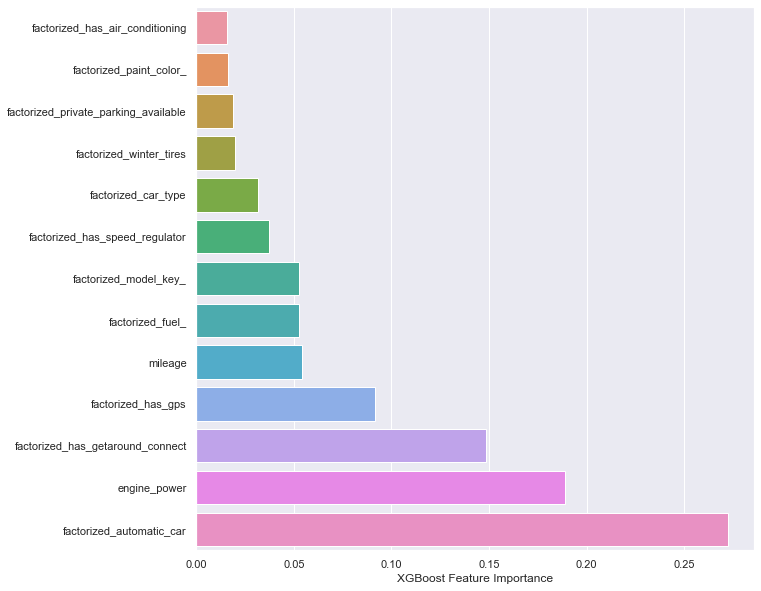

In [20]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sns.set()
sns.barplot(y = X.columns[sorted_idx], x = xgb_regressor.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

**Summary XGBoost**

There are seven parameters with a feature importance more than 5%. These features are listed below:

* automatic_car
* engine_power
* has_getaround_connect
* has_gps
* mileage
* fuel_
* model_key_

## Random forest regressor

In [21]:
# Perform grid search
print("Grid search...")
regressor = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [12, 25],
    'min_samples_split': [4],
    'n_estimators': [50, 300]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 25, 'min_samples_split': 4, 'n_estimators': 300}
Best validation accuracy :  0.7729903503240972


In [22]:
# fit the model with the full train set and predict values for full train an test sets
# create model
random_forest_regressor = RandomForestRegressor(
    n_estimators= 300,
    max_depth= 25,
    min_samples_split= 4,
    random_state= random_state
)

random_forest_regressor.fit(X_train, Y_train)
Y_train_pred = random_forest_regressor.predict(X_train)
Y_test_pred = random_forest_regressor.predict(X_test)

# score full train set
random_forest_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', random_forest_rmse_train)

# score test set
random_forest_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', random_forest_rmse_test)

train RMSE :  5.978955010933849
test RMSE :  13.242892690910853


Text(0.5, 0, 'Random forest feature importance')

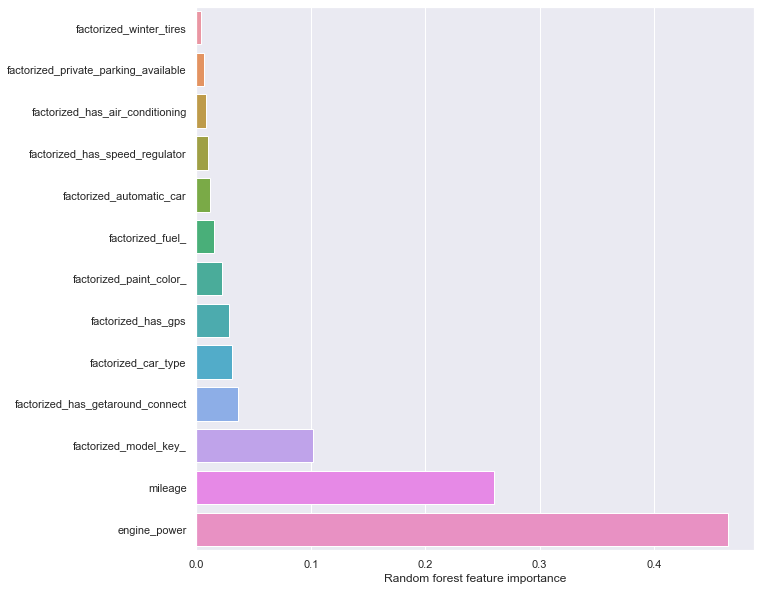

In [23]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = random_forest_regressor.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sns.barplot(y = X.columns[sorted_idx], x = random_forest_regressor.feature_importances_[sorted_idx])
plt.xlabel("Random forest feature importance")

**Summary of Random Forest Regressor**

There are three parameters with a feature importance listed more than 5%. These features are listed below:

* engine_power
* mileage
* model_key_

We can say that random forest model prediction model is very sensitive to these three features. 


## Evaluating robustness of ML models with cross validation

Below, I run the Python script on ML model testing with cross validation and saving scores. I updated this script after finetuning above.

In [24]:
#os.chdir('..//src')
#%run ml_model_testing.py

## Summary of ML experiments

In [25]:
flog = "..\\tracking\\exp_logs.csv"
df0 = pd.read_csv(flog)

In [26]:
#define the metric name: 
# 'rmse_cv', 'r2_score_cv','rmsle_cv', 'mape_cv', 'evs_cv'
metric = 'rmse_cv'

#converting text into a list, creating a proper model name, and then exploding df
df0['index'] = df0.index
df0[metric+'_'] = df0[metric].apply(lambda x: x.replace("  "," ").\
                             replace("  "," ").replace(" ]","]").\
                             replace("[","").replace("]","").split(" ")) 
                          
df0['model_'] = df0['model'].apply(lambda x: x.split('(')[0]) 
df0['model_'] =  df0['index'].astype(str) + '_' +df0['model_']  

df1 = df0.explode(metric + '_').reset_index(drop=True)
df1[metric+'_']= df1[metric+'_'].astype(float)

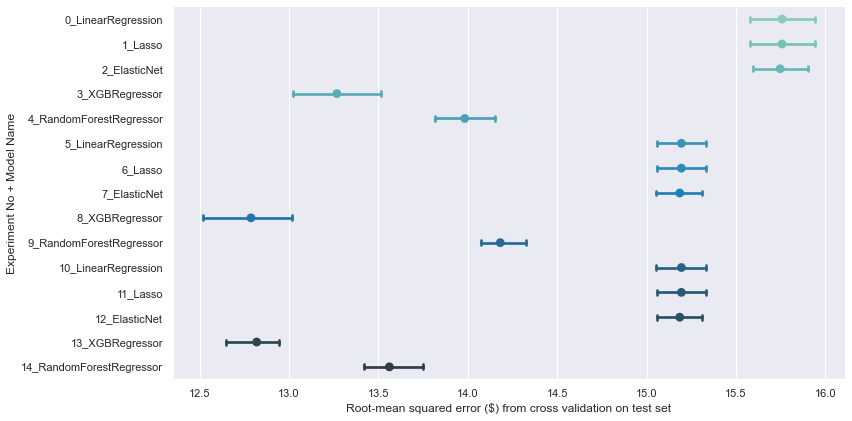

In [27]:
sns.set_theme()
g = sns.catplot(data=df1, y='model_',x= 'rmse_cv_',
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=2. )
g.set_axis_labels("Root-mean squared error ($) from cross validation on test set", "Experiment No + Model Name")
g.savefig('..\\tracking\\rmse_scores_experiments.png')

**Summary of ML Model Experiements**

The test scores of Random Forest and XGBoost regressors are 13.6 and 12.8, respectively. 

XGBoost is the best model with more balanced sensitivity to its features. I select XGBoost to use as a predictive model in deployment.

## Training final model to export

In [28]:
# Separate target variable Y from features X
print("Separating labels from features...")

features_list = [
    "model_key_",
    "mileage",
    "engine_power",
    "fuel_",
    "paint_color_", 
    "car_type",
    "private_parking_available", 
    "has_gps",
    "has_air_conditioning", 
    "automatic_car",
    "has_getaround_connect", 
    "has_speed_regulator",
    "winter_tires"
    ]

target_variable = "rental_price_per_day"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    106
1    101
2    158
3    183
4    131
Name: rental_price_per_day, dtype: int64

X :
  model_key_  mileage  engine_power   fuel_ paint_color_     car_type  \
0    Citroën   140411           100  diesel        black  convertible   
1    Citroën   183297           120  diesel        white  convertible   
2    Citroën   128035           135  diesel          red  convertible   
3    Citroën    97097           160  diesel       silver  convertible   
4    Citroën   152352           225  petrol        black  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car  \
0                       True     True                 False          False   
1                      False    False                 False          False   
2                       True     True                 False          False   
3                       True     True                 False          False   
4                       True  

In [29]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('\nFound numeric features ', numeric_features)
print('\nFound categorical features ', categorical_features)


Found numeric features  ['mileage', 'engine_power']

Found categorical features  ['model_key_', 'fuel_', 'paint_color_', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


In [30]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=0)

print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

# Test pipeline
print("Preprocessing X_test...")
print()
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print()

Preprocessing X_train...

...Done!
  (0, 0)	-0.6654570827503969
  (0, 1)	0.17682920572847943
  (0, 3)	1.0
  (0, 19)	1.0
  (0, 28)	1.0
  (0, 34)	1.0
  (0, 35)	1.0
  (0, 38)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  (1, 0)	-0.37452657210369406
  (1, 1)	-1.1460551530880017
  (1, 2)	1.0
  (1, 22)	1.0
  (1, 29)	1.0
  (1, 35)	1.0
  (1, 39)	1.0
  (1, 40)	1.0
  (2, 0)	-0.6511695542486708
  (2, 1)	-1.1460551530880017
  (2, 11)	1.0
  (2, 22)	1.0
  (2, 30)	1.0
  (2, 35)	1.0
  (2, 36)	1.0
  (2, 40)	1.0
  (3, 0)	0.13967266082695545
  (3, 1)	0.17682920572847943
  (3, 2)	1.0
  (3, 20)	1.0
  (3, 32)	1.0
  (3, 34)	1.0
  (3, 35)	1.0
  (3, 37)	1.0
  (3, 38)	1.0
  (3, 40)	1.0
  (4, 0)	0.47936671496560557
  (4, 1)	0.8382713851367201
  (4, 7)	1.0
  (4, 19)	1.0
  (4, 32)	1.0
  (4, 35)	1.0
  (4, 37)	1.0
  (4, 40)	1.0

Preprocessing X_test...

...Done!
  (0, 0)	-1.189105438116451
  (0, 1)	0.8382713851367201
  (0, 3)	1.0
  (0, 26)	1.0
  (0, 28)	1.0
  (0, 40)	1.0
  (1, 0)	0.47845595617665093
  (1, 1)	0.17682920572847943

In [32]:
# create model
xgb_regressor = xgb.XGBRegressor(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    colsample_bytree=0.9,
    subsample=0.8,
    random_state =0
    )

# fit the model with the full train set and predict values for full train an test sets
xgb_regressor.fit(X_train, Y_train)
Y_train_pred = xgb_regressor.predict(X_train)
Y_test_pred = xgb_regressor.predict(X_test)


# score full train set
xgb_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', round(xgb_rmse_train,2))

# score test set
xgb_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', round(xgb_rmse_test,2))

train RMSE :  9.23
test RMSE :  12.76


In [33]:
# dumping models
joblib.dump(preprocessor, "../api/prepro.joblib")
joblib.dump(xgb_regressor, "../api/finalmodel.joblib")

['../api/finalmodel.joblib']

-_-_-_-_- End of Notebook -_-_-_-_-
# End